In [9]:
#Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import svm
from scipy.stats import norm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from typing import Union
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from IPython.display import display
from time import time
import matplotlib.widgets
from matplotlib.widgets import RadioButtons, CheckButtons
%matplotlib nbagg 
import matplotlib.animation 
from sklearn.inspection import permutation_importance
import random
import pickle

In [10]:
# load models and data needed from last notebook 
X_test = pd.read_csv('X_test.csv', index_col=0).to_numpy()
y_test = pd.read_csv('y_test.csv', index_col=0)['0'].tolist()
X_train = pd.read_csv('X_train.csv', index_col=0).to_numpy()
y_train = pd.read_csv('y_train.csv', index_col=0)['0'].tolist()
forest = pickle.load(open('optimised_forest_model.sav', 'rb'))
forest_y_pred = pd.read_csv('optimised_forest_y_pred.csv', index_col=0)['0'].tolist()
knn_y_pred = pd.read_csv('knn_y_pred.csv', index_col=0)['0'].tolist()
X = pd.read_csv('X.csv', index_col=0).to_numpy()
y = pd.read_csv('y.csv', index_col=0).to_numpy()
name_columns = pd.read_csv('name_columns.csv', index_col=0)['0'].tolist()
data_minmax = pd.read_csv('data_minmax.csv', index_col=0)

# Feature Importance 

The single feature which is mostly correlated to good prediction was determined by using the permutation_importance class from the scikit learn library. A graph is then plotted to help visualize the results. For this dataset,the features tG and EN(B) were consistently ranked as the most important features in the classification. This means that if it were taken out of the classifier, it would decrease the predicticity of the classifier the most. 

<IPython.core.display.Javascript object>


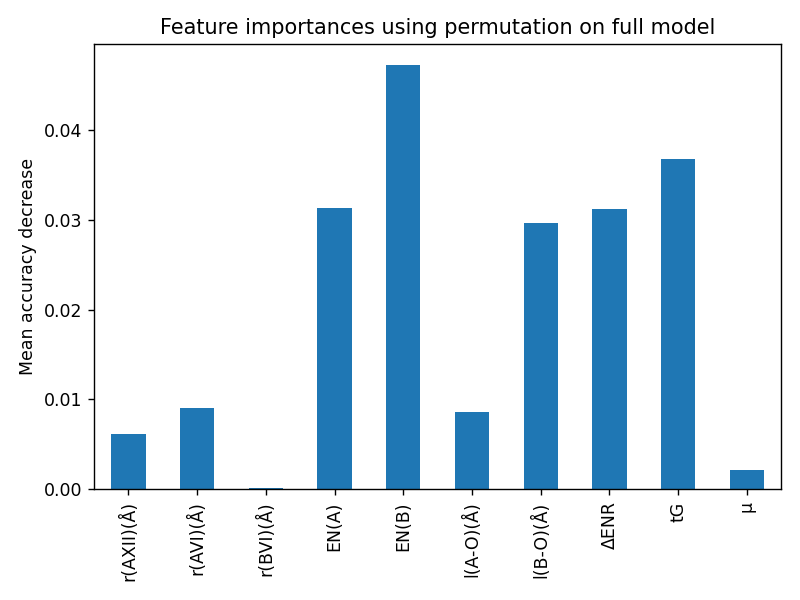

Most important feature: EN(B)


In [3]:
#Feature importance 
def feature_importance(model, X_test, y_test): 
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    forest_importances = pd.Series(abs(result.importances_mean), index=name_columns[:10])
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()
    print(f"Most important feature: {forest_importances.idxmax(axis=1)}")
    return 

feature_importance(forest, X_test, y_test)

# Interactive graph - confusion matrix 

The confusion matrix shows the actual values versus those predicted by the classification method. The matrix changes whilst the order of magnitude of each square remains the same. Initially, the confusion matrix takes into account all of the features, lablelled "all" on the radio buttons. When clicking on any other feature names, that feature would be excluded from the data, which would show the effect of removing it. 

<IPython.core.display.Javascript object>


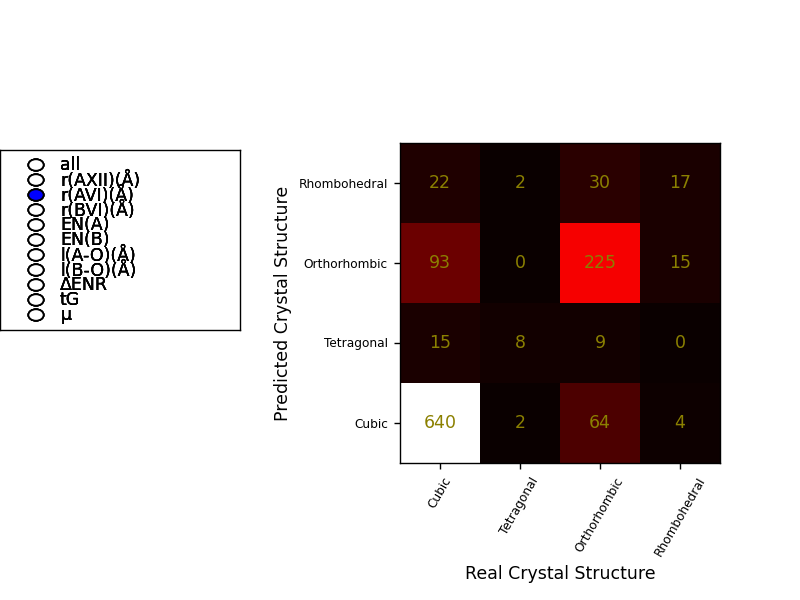

<ipython-input-17-acc52c7e3e98>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  radio_ax = plt.axes([0.0, 0.45, 0.3, 0.3])


0

In [17]:
labels = ["cubic", "tetragonal", "orthorhombic","rhombohedral"]
categories = ('all', 'r(AXII)(Å)', 'r(AVI)(Å)', 'r(BVI)(Å)', 'EN(A)', 'EN(B)', 'l(A-O)(Å)', 'l(B-O)(Å)', 'ΔENR', 'tG', 'μ')

# Dictionary of confusion matrices
confusion_matrix = {}
confusion_matrix[0] = metrics.confusion_matrix(y_test, forest_y_pred, labels=labels)

# Plot confusion matrix 
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.50)

# Get dictionary of confusion matrices, each with a single feature column dropped from the data 
results = categories[slice(1,11)]
for i in results:
    change_data = data_minmax.copy()
    new_data = change_data.drop(columns = i)
    new_names = list(new_data.columns)
    X = new_data[new_names[:9]].to_numpy()
    y = new_data[new_names[9]].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =42)
    # Retrain model with one less feature 
    forest = RandomForestClassifier().fit(X_train, y_train)
    forest_y_pred = forest.predict(X_test)
    index = categories.index(i)
    confusion_matrix[index] = metrics.confusion_matrix(y_test, forest_y_pred, labels=labels)

# Make sure graph of initial full data is displayed 
matrix = confusion_matrix[0]

for y in range(matrix.shape[0]):
    for x in range(matrix.shape[1]):
        ax.text(x, y, matrix[y,x], horizontalalignment='center', verticalalignment='center', color='#8B8000')
        
    # Set radio buttons for the interactive graph 
    radio_ax = plt.axes([0.0, 0.45, 0.3, 0.3])
    radio = RadioButtons(radio_ax, categories)
    
    def callback(label: str='all') -> plt:
        ax.cla()
        index = categories.index(label)
        matrix = confusion_matrix[index]
        ax.imshow(matrix, origin='lower',cmap='hot')
        for y in range(matrix.shape[0]):
            for x in range(matrix.shape[1]):
                ax.text(x, y, matrix[y,x], horizontalalignment='center', verticalalignment='center', color='#8B8000')
        # Set up graph 
        ax.set_xlabel('Real Crystal Structure')
        ax.set_ylabel('Predicted Crystal Structure')
        x_label_list = ['Cubic', 'Tetragonal', 'Orthorhombic', 'Rhombohedral']
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(x_label_list, fontsize=7)
        ax.tick_params(axis="x", labelrotation=-300)
        ax.set_yticks([0,1,2,3])
        ax.set_yticklabels(x_label_list, fontsize=7)
        plt.show()
        return
    
callback()
radio.on_clicked(callback)